In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from LinearRegressionCustom import LinearRegression

# Exploratory Data Analysis

The csv-document is read with pandas and examined with .info()
The file contains 10 features, of which one is categorical, 20640 entries with some nulls in one of the features.

In [2]:
df = pd.read_csv("housing.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The 10 features are examined visually with histograms. This way the distributions can be discearned.
The median_income feature is initially assumed to be distributed according to standard norm. As such it can be used as the respondent variabel Y.

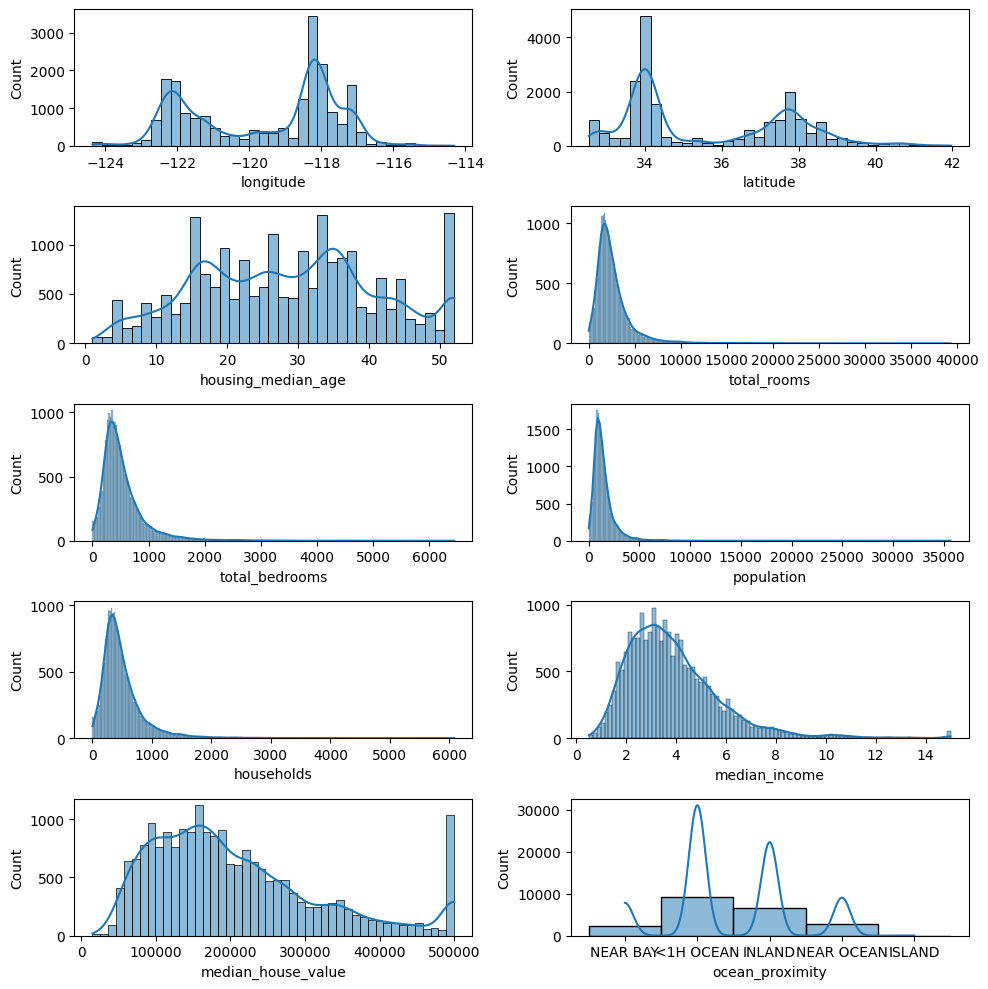

In [3]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(df.columns[0:10]):
    sns.histplot(df[col], kde=True, ax=axes[i])
plt.tight_layout()
plt.show()

With the median income as respondent, features such as "ocean_proximity", "median_house_value" and "households" would be interesting to examine.
The "ocean_proximity" is categorical, "median_house_value" is similar to norm and "households" have a right tilt to it.

The chosen columns are isolated and scaled with the categorical data one-hot-encoded.

In [4]:
df_eda = df.drop(columns=["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population"])
df_eda_encoded = pd.get_dummies(df_eda, columns=["ocean_proximity"], drop_first=False).astype(float)
for col in df_eda_encoded.columns:
    df_eda_encoded[col + "_scaled"] = (df_eda_encoded[col] - df_eda_encoded[col].mean())/df_eda_encoded[col].std()
df_eda_scaled = df_eda_encoded[[col for col in df_eda_encoded.columns if col.endswith("_scaled")]].astype(float)

Pairplot on the non-categorical data reveals that the assumption that the median_income followed a standard distribution was correct.

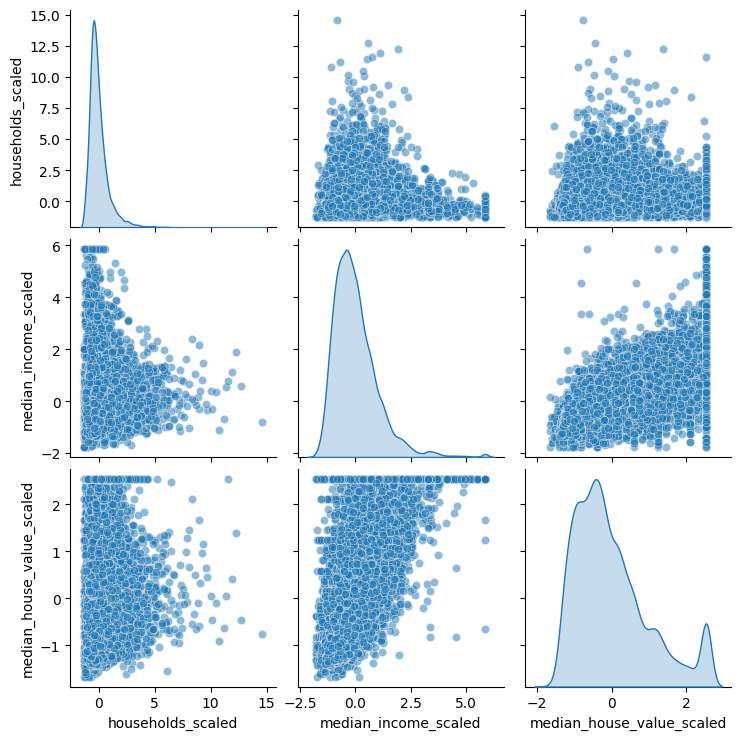

In [5]:
sns.pairplot(df_eda_scaled.drop(columns=["ocean_proximity_ISLAND_scaled", "ocean_proximity_<1H OCEAN_scaled", "ocean_proximity_NEAR BAY_scaled", "ocean_proximity_NEAR OCEAN_scaled", "ocean_proximity_INLAND_scaled"]), diag_kind="kde", plot_kws={"alpha": 0.5})

Scatterplots are created to visualize the correlation for median_house_value and housholds with median_income respectivly 

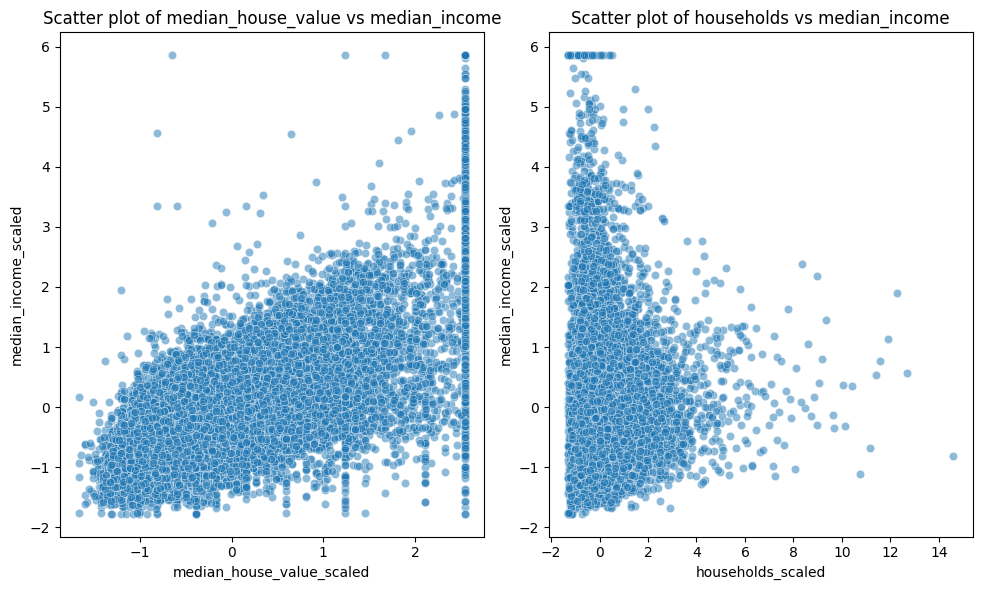

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes = axes.flatten()
cols = ["median_house_value_scaled", "households_scaled"]
for ax, col in zip(axes, cols):
    sns.scatterplot(x=df_eda_scaled[col], y=df_eda_scaled["median_income_scaled"], alpha = 0.5, ax=ax)
    ax.set_title(f"Scatter plot of {col.replace('_scaled', '')} vs median_income")
    ax.set_xlabel(col)
    ax.set_ylabel("median_income_scaled")
plt.tight_layout()
plt.show()

The scatterplots indicate that a linear regression could be useful for this dataset.

Boxplots are created to visualize outliers in the ocean_proximity features.

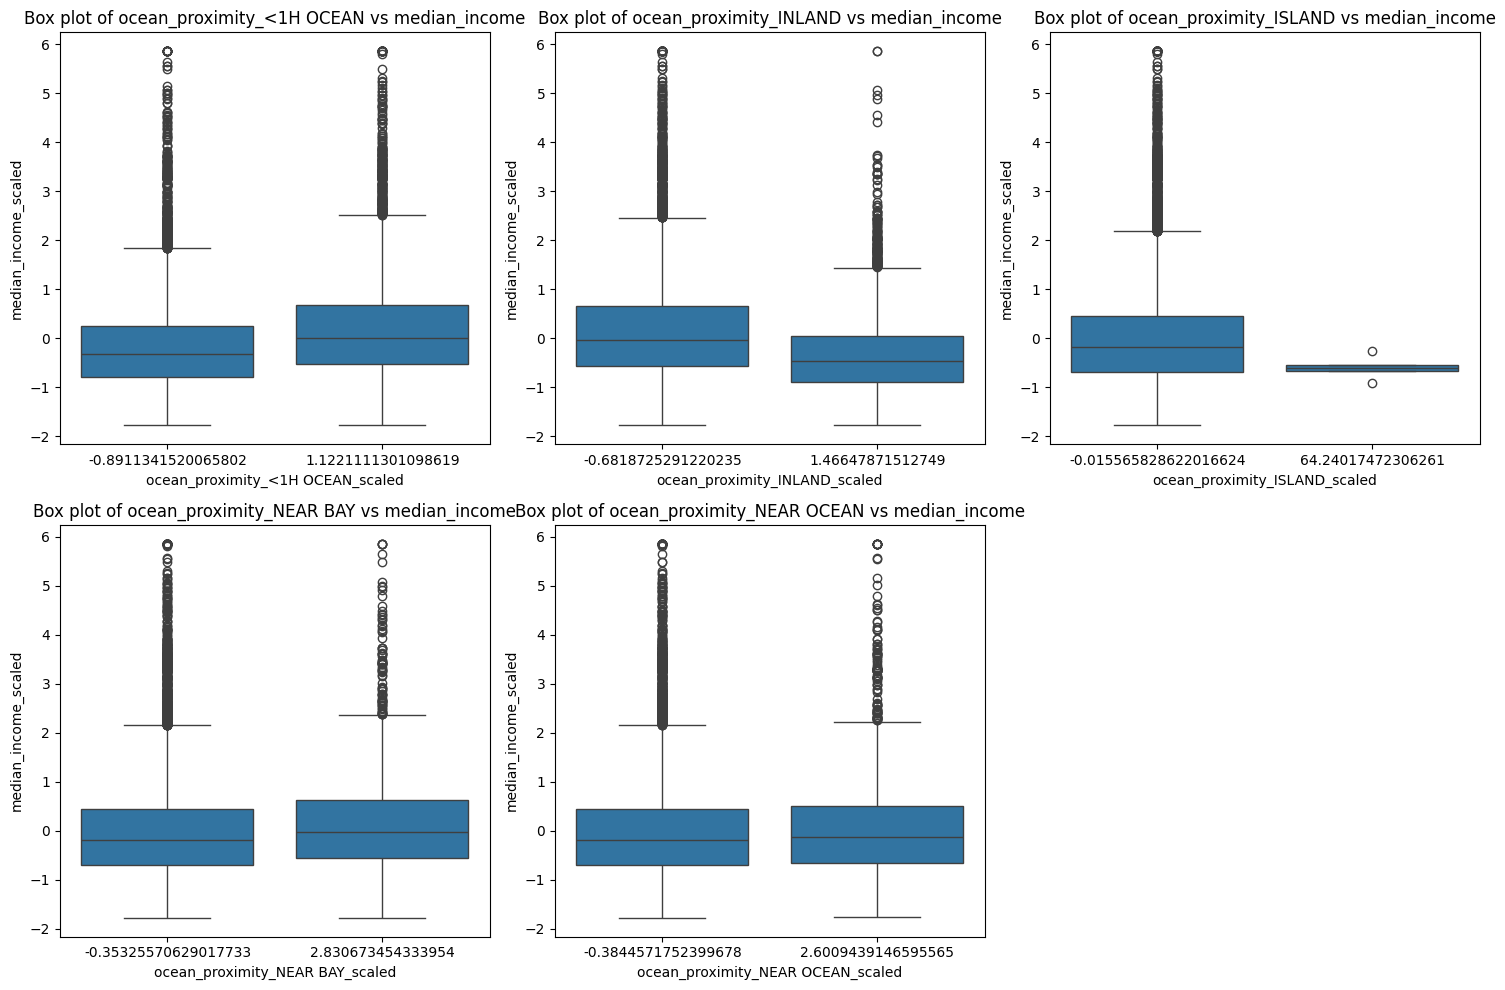

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes = axes.flatten()
cols = ["ocean_proximity_<1H OCEAN_scaled", "ocean_proximity_INLAND_scaled", "ocean_proximity_ISLAND_scaled", "ocean_proximity_NEAR BAY_scaled", "ocean_proximity_NEAR OCEAN_scaled"]
for ax, col in zip(axes, cols):
    sns.boxplot(x=df_eda_scaled[col], y=df_eda_scaled["median_income_scaled"], ax=ax)
    ax.set_title(f"Box plot of {col.replace('_scaled', '')} vs median_income")
    ax.set_xlabel(col)
    ax.set_ylabel("median_income_scaled")

for ax in axes[len(cols):]:
    ax.remove()
    
plt.tight_layout()
plt.show()


The ocean_proximity_ISLAND is unbalanced in its value counts, giving an insight into it's usability. It is suspected that this feature could be removed from the model.

# Examining the statistics

The model from the LinearRegression class is set.

In [8]:
model = LinearRegression()
fit = model.fit(
    X = (df_eda_scaled.drop(columns=["median_income_scaled"])), 
    y = df_eda_scaled["median_income_scaled"])

### Examining the Pearson correlation matrix and related p-value matrix.

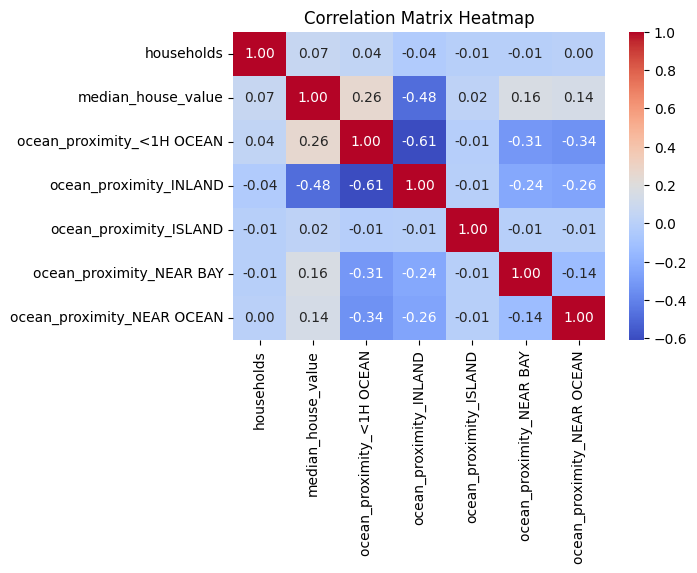

In [9]:
corr, prob_corr = model.pearson_correlation()

feature_names = ['households', 'median_house_value', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
corr_df = pd.DataFrame(corr, index=feature_names, columns=feature_names)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot = True, fmt = ".2f", cmap = "coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

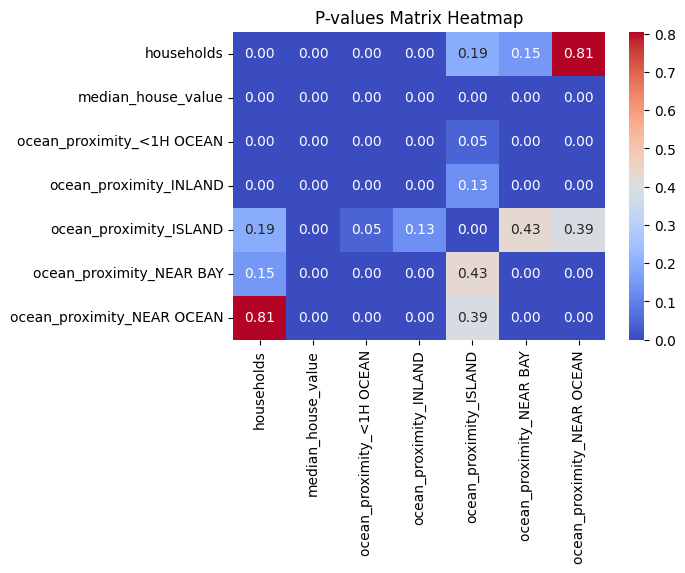

In [10]:
feature_names = ['households', 'median_house_value', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
prob_corr_df = pd.DataFrame(prob_corr, index=feature_names, columns=feature_names)

plt.figure(figsize=(6, 4))
sns.heatmap(prob_corr_df, annot = True, fmt = ".2f", cmap = "coolwarm")
plt.title("P-values Matrix Heatmap")
plt.show()

The corr and prob_corr results shows that the feature "ocean_proximity_ISLAND" is uncorrelated to other features, and therefore contributes no linear information about the other features.
We can therefore remove ocean_proximity_ISLAND.

In [11]:
model = LinearRegression()
fit = model.fit(
    X = (df_eda_scaled.drop(columns=["median_income_scaled", "ocean_proximity_ISLAND_scaled"])), 
    y = df_eda_scaled["median_income_scaled"])

### Examining F-statistic

In [12]:
F, prob_F = model.F_Statistic()
print("F-statistic:", F)
print(f"p_value: {prob_F:.2e}")

F-statistic: 3326.709174643709
p_value: 0.00e+00


The p-value and the F-statistic shows that the model holds great statistical significance.

### Examining R2

In [13]:
R2 = model.R_squared()
print(f"R-squared: {R2:.4f}")

R-squared: 0.4917


The R2 variabel tells us that the model explains 49% of the variation of y (median income). 

### Examining T-statistic.

In [14]:
t_stats, prob_t = model.t_statistic()
print("t-statistics:", t_stats)
print("p-values:", prob_t)

t-statistics: [ 3.76604057e-14 -6.72086045e+00  1.32694551e+02  5.39874113e+00
  6.06433337e+00  4.89917290e+00  4.82827430e+00]
p-values: [1.00000000e+00 1.85370281e-11 0.00000000e+00 6.78510411e-08
 1.34807340e-09 9.69700101e-07 1.38707533e-06]


The B0-koefficient is the interceptor and is therefor statistically insignificant.
The t-statistic and p-value shows that the B1-koefficient(households) is significant and the B2-koefficient(median house value) is greatly significant. The B3, B4, B5 and B6 also hold a statistical significance.

### Examining coefficient estimates with a 95% confidence intervals.

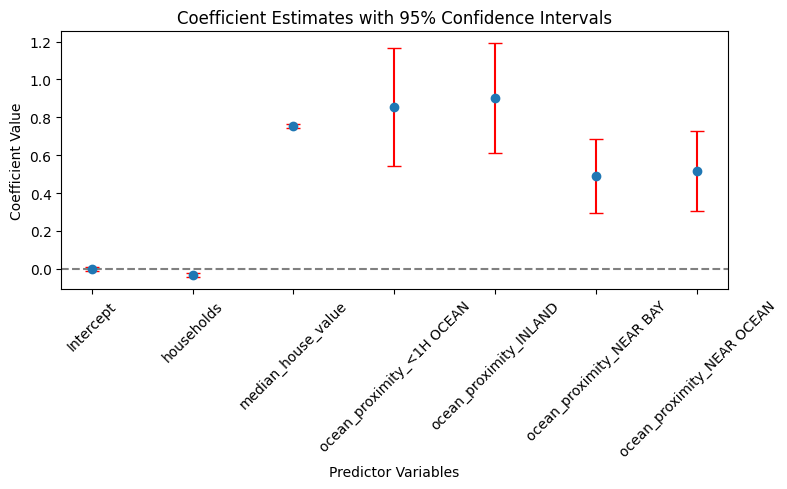

In [17]:
lower, upper = model.confidence_intervals(0.05)
beta = model.beta

plt.figure(figsize=(8, 5))
plt.errorbar(x=np.arange(len(beta)), y=beta, yerr=[beta - lower, upper - beta], fmt='o', ecolor='red', capsize=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(np.arange(len(beta)), ['Intercept', 'households', 'median_house_value', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'], rotation=45)
plt.title('Coefficient Estimates with 95% Confidence Intervals')
plt.xlabel('Predictor Variables')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

The graph gives a visual of the effect each parameter has on the respondent variabel. median_house_value holds the greatest positive effect, with ocean proximity: <1H and inland , holding a medium possitive effect compared to the island dummy feature that was dropped.
Households however hold a negative effect, resulting in a reduced median income as Households is increased.

### Examining the significance and confidence level.

In [16]:
alpha = 0.05
if prob_F < alpha:
    print("The model is statistically significant at 95% confidence level.")
if np.any(prob_t < alpha):
    print("The coefficient is statistically significant at 95% confidence level.")
if np.any(prob_corr < alpha):
    print("There are statistically significant correlations between the features at 95% confidence level.")

The model is statistically significant at 95% confidence level.
The coefficient is statistically significant at 95% confidence level.
There are statistically significant correlations between the features at 95% confidence level.


# Conclusion

The model holds statistiscal significance at 95% confidence level, meaning that it is a reliable predicator for the data.
